# ANALYSE TRANSACTIONS IMMOBILIÈRES & DIVERS FACTEURS EXPLICATIFS

## Lecture du fichier et nettoyage minimum (dates et types de données)

In [2]:
# On importe pandas pour manipuler des tableaux de données
import pandas as pd

# On importe numpy pour gérer correctement les valeurs manquantes et numériques
import numpy as np


# Chemin vers le fichier DVF (données des transactions immobilières)
FILE_PATH = "/home/onyxia/Projet-Python-2A-ENSAE/ValeursFoncieres-2025-S1.csv"


# --- LECTURE DU FICHIER DVF ---

# On lit le fichier CSV avec pandas
df = pd.read_csv(
    FILE_PATH,        # chemin du fichier
    sep="|",           # les colonnes sont séparées par le caractère |
    dtype=str,         # on lit tout comme du texte pour éviter les erreurs de type
    decimal=",",       # les nombres utilisent une virgule comme séparateur décimal
    na_values=["", " "],  # les champs vides sont considérés comme des valeurs manquantes
    engine="python"    # moteur plus tolérant pour les fichiers DVF
)


# --- NETTOYAGE DE BASE DES VARIABLES ---

# Conversion de la date de mutation en vrai format date
# Le format est jour/mois/année
df["Date mutation"] = pd.to_datetime(
    df["Date mutation"],
    format="%d/%m/%Y",
    errors="coerce"    # les dates invalides deviennent NaT
)

# Conversion de la valeur foncière en nombre
# On remplace la virgule par un point puis on convertit en float
df["Valeur fonciere"] = (
    df["Valeur fonciere"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Conversion de la surface du terrain en nombre
# Les valeurs non valides deviennent NaN
df["Surface terrain"] = pd.to_numeric(
    df["Surface terrain"],
    errors="coerce"
)

# Conversion de la surface réelle bâtie en nombre
df["Surface reelle bati"] = pd.to_numeric(
    df["Surface reelle bati"],
    errors="coerce"
)

# Conversion du nombre de pièces principales en nombre
df["Nombre pieces principales"] = pd.to_numeric(
    df["Nombre pieces principales"],
    errors="coerce"
)


# --- OPTIONS D’AFFICHAGE (CONFORT DE LECTURE) ---

# On affiche toutes les colonnes sans les couper
pd.set_option("display.max_columns", None)

# On augmente la largeur d’affichage du tableau
pd.set_option("display.width", 2000)

# On limite l’affichage à 20 lignes
pd.set_option("display.max_rows", 20)


# --- VÉRIFICATIONS DE BASE ---

# Affichage des premières lignes du DataFrame
print(df.head())

# Affichage de la liste des colonnes
print(df.columns)

# Affichage du nombre total de lignes
print(f"Nombre de lignes : {len(df)}")


  Identifiant de document Reference document 1 Articles CGI 2 Articles CGI 3 Articles CGI 4 Articles CGI 5 Articles CGI No disposition Date mutation Nature mutation  Valeur fonciere No voie B/T/Q Type de voie Code voie              Voie Code postal    Commune Code departement Code commune Prefixe de section Section No plan No Volume 1er lot Surface Carrez du 1er lot 2eme lot Surface Carrez du 2eme lot 3eme lot Surface Carrez du 3eme lot 4eme lot Surface Carrez du 4eme lot 5eme lot Surface Carrez du 5eme lot Nombre de lots Code type local  Type local Identifiant local  Surface reelle bati  Nombre pieces principales Nature culture Nature culture speciale  Surface terrain
0                     NaN                NaN            NaN            NaN            NaN            NaN            NaN         000001    2025-01-07           Vente         468000.0     NaN   NaN          NaN      B078            FARGES        1550     FARGES               01          158                NaN       B     8

In [3]:
# On supprime les biens dont la surface bâtie est négative ou nulle
df = df[df["Surface reelle bati"] > 0]

# On supprime les valeurs foncières négatives ou nulles
df = df[df["Valeur fonciere"] > 0]


In [6]:
# Liste des colonnes jugées non pertinentes pour l'analyse économique
colonnes_hors_perimetre = [
    "1 Articles CGI",
    "2 Articles CGI",
    "3 Articles CGI",
    "4 Articles CGI",
    "5 Articles CGI",
    "Identifiant de document",
    "Reference document"
]


In [14]:
# Comptage des types de locaux présents dans la base
df["Type local"].value_counts(dropna=False)


Type local
Maison                                      218368
Appartement                                 185097
Local industriel. commercial ou assimilé     41010
Name: count, dtype: int64

## Définition du périmètre : biens résidentiels uniquement

La base DVF contient à la fois des biens résidentiels et des biens non résidentiels
(locaux industriels, commerciaux ou assimilés).

Dans ce projet, nous nous concentrons exclusivement sur le **marché du logement**.
Nous restreignons donc l’échantillon aux **maisons et appartements**, en nous appuyant
sur la variable *Type local*.

Ce filtrage permet d’éviter que des biens atypiques (entrepôts, locaux commerciaux,
bâtiments industriels) ne biaisent l’analyse des prix et des surfaces.


In [15]:
# Filtrage des biens résidentiels : maisons et appartements uniquement
df = df[df["Type local"].isin(["Maison", "Appartement"])]

# Vérification après filtrage
df["Type local"].value_counts()

Type local
Maison         218368
Appartement    185097
Name: count, dtype: int64

## Choix de la variable cible : le prix au mètre carré

Dans ce projet, nous cherchons à expliquer et à prédire le niveau des prix immobiliers à partir des caractéristiques des biens et de leur environnement.

Nous avons choisi comme **variable cible** le **prix au mètre carré**, noté *Valeur m2*, plutôt que la valeur foncière totale.

Ce choix s’explique par plusieurs raisons :

- le prix au mètre carré permet de comparer des biens de tailles différentes sur une base homogène ;
- il neutralise l’effet mécanique de la surface sur le prix total ;
- il est largement utilisé dans les analyses immobilières (agents immobiliers, notaires, études économiques) ;
- il est plus pertinent pour analyser les variations spatiales et structurelles des prix.

Avant de calculer cette variable, nous avons vérifié que la surface réelle bâtie était strictement positive afin d’éviter toute incohérence mathématique (division par zéro).

Le prix au mètre carré est alors défini comme le rapport entre la valeur foncière et la surface réelle bâtie du bien.


In [16]:
target = "Valeur m2"


# --- CALCUL DU PRIX AU MÈTRE CARRÉ ---

# Avant le calcul, on conserve uniquement les biens dont la surface bâtie est strictement positive.
# Cela évite toute division par zéro ou incohérence mathématique.
df = df[df["Surface reelle bati"] > 0]

# Calcul du prix au mètre carré.
# Le prix au m² est défini comme la valeur foncière divisée par la surface réelle bâtie.
df["Valeur m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]


# --- VÉRIFICATION DE COHÉRENCE ---

# Affichage de statistiques descriptives pour vérifier l’ordre de grandeur du prix au m².
# Cette étape permet de détecter d’éventuelles valeurs aberrantes avant l’analyse.
df["Valeur m2"].describe()


count    4.034650e+05
mean     1.352117e+04
std      1.209147e+05
min      3.533569e-03
25%      1.704009e+03
50%      2.710938e+03
75%      4.444444e+03
max      2.773333e+07
Name: Valeur m2, dtype: float64

## Stabilisation de la variable cible pour l’analyse descriptive

L’analyse de la distribution du prix au mètre carré met en évidence la présence de valeurs extrêmes irréalistes, aussi bien très faibles que très élevées.  
Ces observations correspondent à des anomalies de la base DVF ou à des biens atypiques.

Afin d’améliorer la lisibilité des graphiques et d’éviter que ces valeurs ne dominent l’analyse descriptive, nous appliquons un filtrage statistique basé sur les quantiles.

Concrètement, nous conservons uniquement les observations comprises entre les quantiles 5 % et 95 % du prix au mètre carré.  
Ce filtrage est utilisé uniquement pour l’exploration des données et n’affecte pas le jeu de données utilisé pour la modélisation.

In [17]:
# Calcul des seuils 5 % et 95 % du prix au m²
q_low = df["Valeur m2"].quantile(0.05)
q_high = df["Valeur m2"].quantile(0.95)

# Création d'un DataFrame filtré pour l'analyse descriptive
df_eda = df[(df["Valeur m2"] >= q_low) & (df["Valeur m2"] <= q_high)]

# Vérification rapide
df_eda["Valeur m2"].describe()


count    363179.000000
mean       3408.994410
std        2374.162398
min         714.285714
25%        1798.843892
50%        2710.709677
75%        4183.673469
max       13935.483871
Name: Valeur m2, dtype: float64

In [22]:
# Statistiques de surface après filtrage résidentiel
df["Surface reelle bati"].describe()


count    403465.000000
mean         81.257482
std          46.251493
min           1.000000
25%          50.000000
50%          75.000000
75%         102.000000
max        1469.000000
Name: Surface reelle bati, dtype: float64

## Analyse descriptive du prix au mètre carré

Nous commençons par analyser la distribution du prix au mètre carré (*Valeur m2*) sur les données stabilisées pour l’analyse descriptive.

Cette étape permet de :
- vérifier les ordres de grandeur ;
- observer la dispersion des prix ;
- identifier d’éventuelles asymétries de la distribution.


<Axes: ylabel='Frequency'>

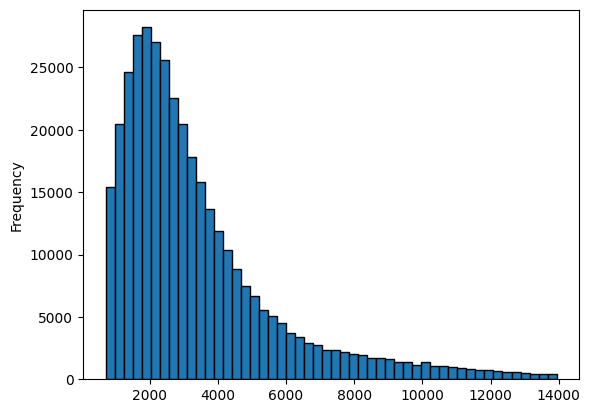

In [18]:
# Histogramme du prix au m²
df_eda["Valeur m2"].plot.hist(
    bins=50,
    edgecolor="black"
)

<Axes: >

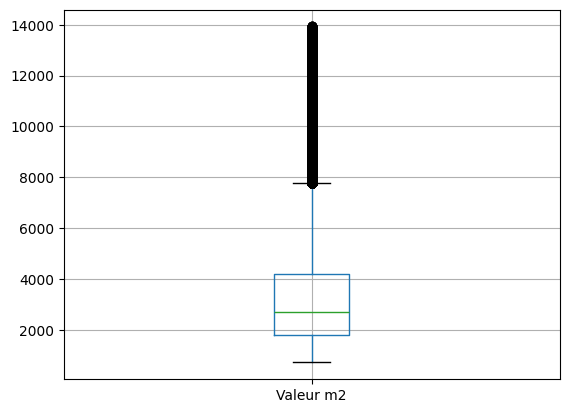

In [19]:
# Boxplot du prix au m²
df_eda.boxplot(column="Valeur m2")


> La présence de nombreux outliers à la hausse reflète la forte hétérogénéité du marché immobilier, avec des biens situés dans des zones très tendues ou atypiques.


## Effet taille : relation entre surface et prix au mètre carré

Nous étudions maintenant la relation entre la surface réelle bâtie et le prix au mètre carré.

En immobilier, il est courant d’observer un **effet taille** :
à mesure que la surface augmente, le prix au m² tend à diminuer.


<Axes: xlabel='Surface reelle bati', ylabel='Valeur m2'>

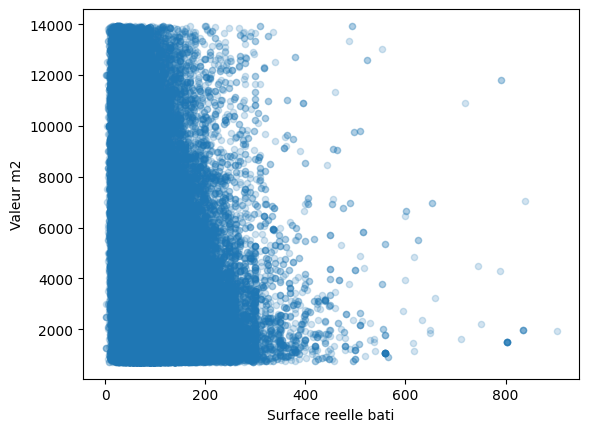

In [20]:
# Nuage de points : surface bâtie vs prix au m²
df_eda.plot.scatter(
    x="Surface reelle bati",
    y="Valeur m2",
    alpha=0.2
)


## Comparaison maisons vs appartements

Nous comparons maintenant les prix au mètre carré entre maisons et appartements.
Ces deux types de biens obéissent à des logiques de marché différentes,
ce qui peut expliquer des niveaux de prix et des effets taille distincts.


<Axes: title={'center': 'Valeur m2'}, xlabel='Type local'>

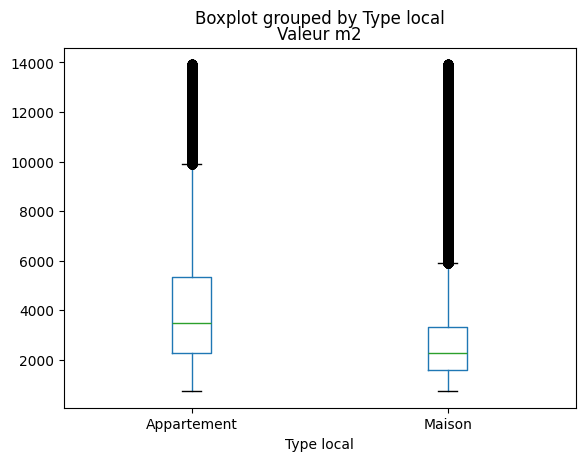

In [23]:
# Boxplot du prix au m² par type de bien
df_eda.boxplot(
    column="Valeur m2",
    by="Type local",
    grid=False
)


> Le boxplot montre une différence nette de niveau de prix entre appartements et maisons.
Les appartements présentent un prix au mètre carré médian plus élevé et une dispersion plus importante, ce qui reflète leur localisation plus fréquente en zones urbaines tendues.
Cette observation justifie l’intégration du type de bien comme variable explicative clé.

## Première régression linéaire

Nous estimons une régression linéaire afin d’expliquer le prix au mètre carré (*Valeur m2*)
à partir de caractéristiques intrinsèques du logement.

Variables explicatives retenues :
- la surface réelle bâtie (effet taille) ;
- le type de bien (maison ou appartement) ;
- le nombre de pièces principales.

Remarque : notre jeu de données ne couvre que l’année 2025, donc nous n’introduisons pas de variable temporelle.

In [39]:
# Import des fonctions pour découper le jeu de données en apprentissage / test
from sklearn.model_selection import train_test_split

# Import du modèle de régression linéaire
from sklearn.linear_model import LinearRegression

# Import de la métrique R² pour évaluer la performance du modèle
from sklearn.metrics import r2_score

# Import de pandas pour manipuler les tableaux et afficher les coefficients
import pandas as pd

## Préparation des données pour la régression

Nous créons une variable binaire pour représenter le type de bien :
- Appartement = 1
- Maison = 0

Nous sélectionnons ensuite les variables explicatives et la variable cible.
Enfin, nous supprimons les lignes avec valeurs manquantes pour éviter les erreurs lors de l’entraînement.

In [40]:
# Copie du jeu de données pour éviter de modifier df directement
df_model = df.copy()

# Encodage du type de bien : 1 si appartement, 0 si maison
df_model["Appartement"] = (df_model["Type local"] == "Appartement").astype(int)

# Sélection des variables explicatives
X = df_model[["Surface reelle bati", "Appartement", "Nombre pieces principales"]]

# Sélection de la variable cible
y = df_model["Valeur m2"]

# Construction d'un DataFrame combiné pour supprimer les lignes incomplètes
df_model_clean = pd.concat([X, y], axis=1)

# Suppression des lignes contenant au moins une valeur manquante
df_model_clean = df_model_clean.dropna()

# Redéfinition de X et y après nettoyage
X = df_model_clean[["Surface reelle bati", "Appartement", "Nombre pieces principales"]]
y = df_model_clean["Valeur m2"]

In [41]:
# Séparation train / test (80 % / 20 %), avec une graine fixe pour la reproductibilité
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Création du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul du score R²
r2 = r2_score(y_test, y_pred)

# Affichage du score R²
r2


0.010396982394627385

In [ ]:
# Création d'une série pour afficher proprement les coefficients
coefficients = pd.Series(
    model.coef_,
    index=X.columns,
    name="Coefficient"
)

# Affichage des coefficients
coefficients


np.float64(10491.714840840192)

In [45]:
model.intercept_


np.float64(10491.714840840192)

### Passage à une spécification logarithmique

In [46]:
# Transformation logarithmique
X_log = X.copy()
X_log["Surface reelle bati"] = np.log(X_log["Surface reelle bati"])
y_log = np.log(y)

# Train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# Modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions et R²
r2_log = r2_score(y_test, model.predict(X_test))
r2_log


0.09887892104850804

> En passant à une spécification logarithmique, le pouvoir explicatif du modèle augmente nettement.
Le R² atteint environ 10 %, ce qui confirme que les caractéristiques intrinsèques du logement expliquent une partie non négligeable du prix au mètre carré.
La part restante s’explique principalement par la localisation, que nous introduirons dans un second temps.

## Ajout d’une variable de localisation : le département

Avant d’introduire une localisation fine (coordonnées, distances), nous ajoutons
une variable géographique simple : le **département**.

Le département permet de capter des différences régionales de prix
(tension du marché, attractivité, niveau de vie),
tout en restant une information grossière et facile à interpréter.

Cette étape permet de mesurer l’apport de la localisation
par rapport à un modèle basé uniquement sur les caractéristiques du logement.


In [47]:
# Copie du jeu de données pour la modélisation
df_model = df.copy()

# Encodage du type de bien : Appartement = 1, Maison = 0
df_model["Appartement"] = (df_model["Type local"] == "Appartement").astype(int)

# Conversion du code département en chaîne de caractères
# (important pour traiter correctement des codes comme "01", "2A", "2B")
df_model["Code departement"] = df_model["Code departement"].astype(str)

In [49]:
# Création des variables indicatrices (one-hot encoding) pour les départements
# drop_first=True évite la colinéarité parfaite
departement_dummies = pd.get_dummies(
    df_model["Code departement"],
    prefix="Dep",
    drop_first=True
)

In [50]:
# Variables explicatives numériques (log-transformées)
X_num = df_model[
    ["Surface reelle bati", "Appartement", "Nombre pieces principales"]
].copy()

# Transformation logarithmique de la surface
X_num["Surface reelle bati"] = np.log(X_num["Surface reelle bati"])

# Assemblage final des variables explicatives
X = pd.concat([X_num, departement_dummies], axis=1)

# Variable cible en log
y = np.log(df_model["Valeur m2"])

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Suppression des lignes incomplètes
df_model_clean = pd.concat([X, y], axis=1).dropna()
X = df_model_clean[X.columns]
y = df_model_clean[y.name]

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Évaluation
r2_dep = r2_score(y_test, model.predict(X_test))
r2_dep

0.26180538906087225

L’ajout du département améliore fortement le pouvoir explicatif du modèle ($R^2 = 26%$).
Cela confirme que la localisation explique une part majeure des différences
de prix au mètre carré.

Cette variable capte des effets régionaux (tension du marché, attractivité),
sans recourir à une localisation fine.